# Analysis

This notebook may be copied and used to analyse the output of jam-ensemble.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
path_to_logs = '../test/logs'
path_to_save = '../test/results'

if not os.path.isdir(path_to_save):
    os.makedirs(path_to_save)

In [5]:
target_dirs = [f.path for f in os.scandir(path_to_logs) if f.is_dir()]
target_dirs

['../test/logs/KIC4448777']

In [8]:
target_ids = [f.name for f in os.scandir(path_to_logs) if f.is_dir()]
target_ids

['KIC4448777']

## Asymptotic fit results

In [9]:
statistics = ['mean', 'std', '16th', '50th', '84th']
names = ['dnu', 'numax', 'eps', 'd02', 'alpha', 'env_height', 'env_width',
        'mode_width', 'teff', 'bp_rp']
cols = []
log_cols = []
for n in names:
    for s in statistics:
        log_cols.append('log_' + n + '_' + s)
        cols.append(n + '_' + s)

In [12]:
# row = 0
asy_results = pd.DataFrame(columns=cols+log_cols, index=target_ids)

for target_dir, target_id in zip(target_dirs, target_ids):

    path = os.path.join(target_dir, f'asy_fit_summary_{target_id}.csv')        
    try:
        asy_results_temp = pd.read_csv(path)
    except FileNotFoundError:
        print(f'File not found at {path}, no results for this target.')
        continue

    # asy_results.at[row, 'target_id'] = target_id

    data = []
    log_data = []
    for s in statistics:
        if s == 'std':
            log_data.append(asy_results_temp[s].values)  # Log
            data.append(asy_results_temp[s].values * 10**asy_results_temp['mean'].values * np.log(10))  # Base-10
        else:
            log_data.append(asy_results_temp[s].values)  # Log
            data.append(10**asy_results_temp[s].values)  # Base-10
    data = np.array(data).flatten('F')
    log_data = np.array(log_data).flatten('F')
    data = np.append(data, log_data)
    # print(data)
    asy_results.loc[target_id] = data  # Add data to dataframe

    # row += 1

asy_results.head()

,dnu_mean,dnu_std,dnu_16th,dnu_50th,dnu_84th,numax_mean,numax_std,numax_16th,numax_50th,numax_84th,...,log_teff_mean,log_teff_std,log_teff_16th,log_teff_50th,log_teff_84th,log_bp_rp_mean,log_bp_rp_std,log_bp_rp_16th,log_bp_rp_50th,log_bp_rp_84th
KIC4448777,17.0115,0.0064659,17.005,17.0114,17.0179,221.8,0.63476,221.165,221.81,222.439,...,3.70026,0.00457021,3.6954,3.70124,3.70429,1.24126,0.0503817,1.19173,1.24259,1.29022


In [16]:
not_log = ['bp_rp', 'eps']

for n in not_log:
    for s in statistics:
        asy_results['_'.join([n, s])] = asy_results['_'.join(['log', n, s])]
        asy_results.drop(columns='_'.join(['log', n, s]), inplace=True)

asy_results.head()

,dnu_mean,dnu_std,dnu_16th,dnu_50th,dnu_84th,numax_mean,numax_std,numax_16th,numax_50th,numax_84th,...,log_mode_width_mean,log_mode_width_std,log_mode_width_16th,log_mode_width_50th,log_mode_width_84th,log_teff_mean,log_teff_std,log_teff_16th,log_teff_50th,log_teff_84th
KIC4448777,17.0115,0.0064659,17.005,17.0114,17.0179,221.8,0.63476,221.165,221.81,222.439,...,-0.661531,0.0222031,-0.683298,-0.661921,-0.639101,3.70026,0.00457021,3.6954,3.70124,3.70429


In [20]:
asy_results = asy_results.astype(np.float64)

In [58]:
asy_results.to_csv(os.path.join(path_to_save, 'asy_summary.csv'), index=False)

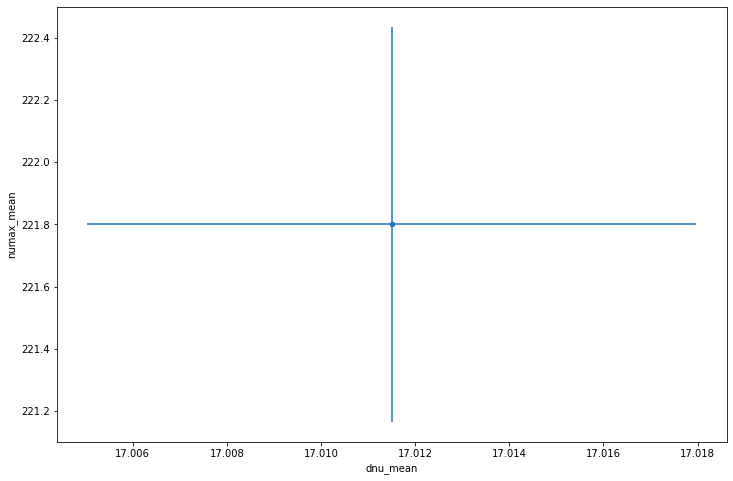

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))

asy_results.plot(ax=ax, kind='scatter', x='dnu_mean', y='numax_mean',
                xerr='dnu_std', yerr='numax_std')

## Peakbagging results

In [106]:
def flag_uninformative_data(data, idx, acceptance=0.95, f_sd=0.03):
    ''' Flag uninformative data. This is given by results for which the 
    standard deviation over the prior standard deviation is above the 
    acceptance fraction (default is 95%). The prior standard deviation
    is f_sd (default is 0.03) multiplied by delta_nu.'''
    dnu = asy_results.loc[idx, 'dnu_mean']
    prior_sd = f_sd * dnu
    data['nu_sd_over_prior_sd'] = data['sd'] / prior_sd
    data['uninformative_data'] = (data['nu_sd_over_prior_sd'] > acceptance).astype(int)

In [107]:
save_paths = []
no_peakbag = []

statistics = ['mean', 'sd']
cols_to_save = ['l'] + [f'nu_{s}' for s in statistics] + ['nu_sd_over_prior_sd', 'uninformative_data']
save = lambda x: f'{x}_peakbag.csv'

In [108]:
all_results = {}

for target_dir, target_id in zip(target_dirs, target_ids):

    path = os.path.join(target_dir, f'peakbag_summary_{target_id}.csv')
    
    try:
        df_temp = pd.read_csv(path, index_col=0)
    except FileNotFoundError:
        print(f'File not found at {path}, no peakbag results for this target.')
        no_peakbag.append(target_ids)
        continue

    df = df_temp.loc[df_temp.index.str.startswith('l'), statistics]
    df['l'] = df.index.str.slice(1, 2)
    flag_uninformative_data(df, target_id)

    save_path = os.path.join(path_to_save, save(target_id))
    
    df = df.rename(columns={s: f'nu_{s}' for s in statistics})
    
    all_results[target_id] = df[cols_to_save] 
    df[cols_to_save].to_csv(save_path, index=False)


In [109]:
peakbag_results = pd.concat(all_results)
peakbag_results.index = peakbag_results.index.rename('id', level=0)
peakbag_results.head()

l     nu_mean     nu_sd  nu_sd_over_prior_sd  \
id         name                                                  
KIC4448777 l0__0  0  143.085589  0.518117             1.015229   
           l0__1  0  159.838651  0.028390             0.055628   
           l0__2  0  176.269217  0.019016             0.037262   
           l0__3  0  192.920943  0.015622             0.030611   
           l0__4  0  209.924645  0.008639             0.016927   

                  uninformative_data  
id         name                       
KIC4448777 l0__0                   1  
           l0__1                   0  
           l0__2                   0  
           l0__3                   0  
           l0__4                   0

In [110]:
results = pd.DataFrame(peakbag_results.to_records()).merge(asy_results, left_on='id', right_index=True)
results.head()

,id,name,l,nu_mean,nu_sd,nu_sd_over_prior_sd,uninformative_data,dnu_mean,dnu_std,dnu_16th,...,log_mode_width_mean,log_mode_width_std,log_mode_width_16th,log_mode_width_50th,log_mode_width_84th,log_teff_mean,log_teff_std,log_teff_16th,log_teff_50th,log_teff_84th
0,KIC4448777,l0__0,0,143.085589,0.518117,1.015229,1,17.011504,0.006466,17.005005,...,-0.661531,0.022203,-0.683298,-0.661921,-0.639101,3.700264,0.00457,3.6954,3.701239,3.704293
1,KIC4448777,l0__1,0,159.838651,0.028390,0.055628,0,17.011504,0.006466,17.005005,...,-0.661531,0.022203,-0.683298,-0.661921,-0.639101,3.700264,0.00457,3.6954,3.701239,3.704293
2,KIC4448777,l0__2,0,176.269217,0.019016,0.037262,0,17.011504,0.006466,17.005005,...,-0.661531,0.022203,-0.683298,-0.661921,-0.639101,3.700264,0.00457,3.6954,3.701239,3.704293
3,KIC4448777,l0__3,0,192.920943,0.015622,0.030611,0,17.011504,0.006466,17.005005,...,-0.661531,0.022203,-0.683298,-0.661921,-0.639101,3.700264,0.00457,3.6954,3.701239,3.704293
4,KIC4448777,l0__4,0,209.924645,0.008639,0.016927,0,17.011504,0.006466,17.005005,...,-0.661531,0.022203,-0.683298,-0.661921,-0.639101,3.700264,0.00457,3.6954,3.701239,3.704293


In [112]:
results['nu_mod_dnu'] = results['nu_mean'] % results['dnu_mean']
results['nu_over_dnu'] = results['nu_mean'] / results['dnu_mean']

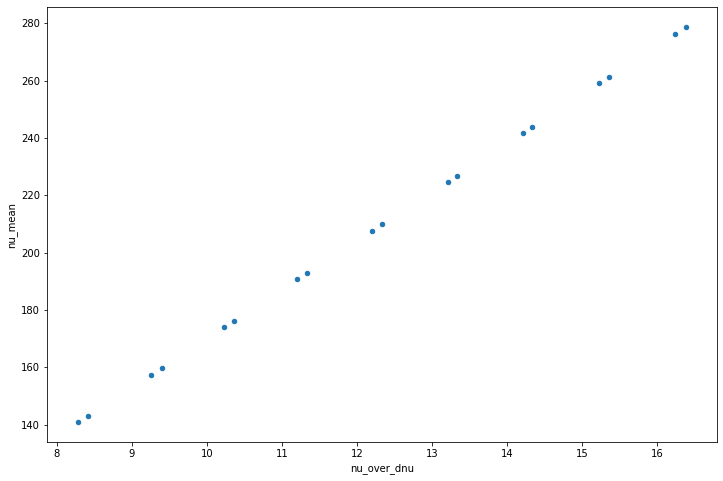

In [114]:
fig, ax = plt.subplots(figsize=(12, 8))

results.plot(ax=ax, kind='scatter', x='nu_over_dnu', y='nu_mean')